### Pill 14 WIKI Side Quest: Mixture of Gaussians

Create an artificial data set the breaks the assumtions of Mixture of Gaussians as computed in class. Report and comment this. Highlight how one could handle the proposed datas set.


The following code generates a dataset that breaks the assumtions of the Mixture of Gaussians algorithm computed in class. It consists of ...


In [154]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin
from scipy.spatial.distance import cdist

In [220]:
def point(n,r,t1,t2,b):
    # random angle
    alpha = 2 * np.pi * np.random.rand(n,1)
    # random radius
    r = r * np.sqrt(np.random.rand(n,1))
    # calculating coordinates
    x = r * np.cos(alpha)
    y = r * np.sin(alpha) 
    y = y.T[0]
    x = x.T[0]
    y[y < b] = -y[y < b]

    Z = np.c_[x,y] + np.c_[np.repeat(t1, n), np.repeat(t2,n)]
    return (Z)


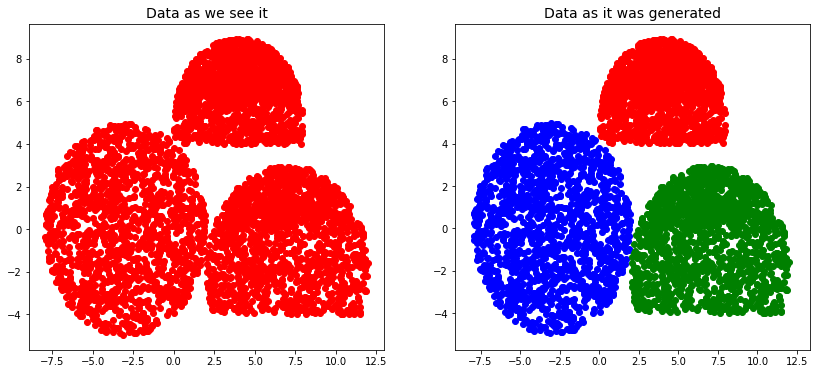

In [222]:
#Create some data
MAXN=1500
X = point(MAXN, 5,-3,0,5)
X = np.concatenate([X,point(MAXN,5,7,-2,2), point(MAXN,4,4,5,-1)])
#print(X.shape)

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1)), 3*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))


[[ 0.38358953  0.75648755]
 [ 0.66119613 -0.44702908]
 [ 0.48694203  0.11425405]]


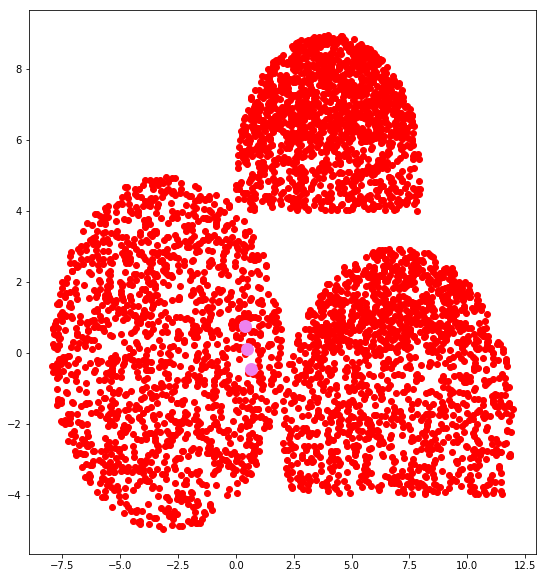

In [223]:
K =3
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print (C)

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((20,10))

[[ 1.95923628  0.79494186]
 [15.74417322  0.55027473]
 [15.34319538  0.94906576]] [[0.32733932]
 [0.27107896]
 [0.40158172]]


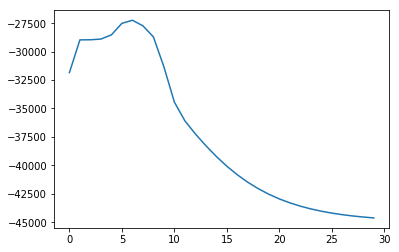

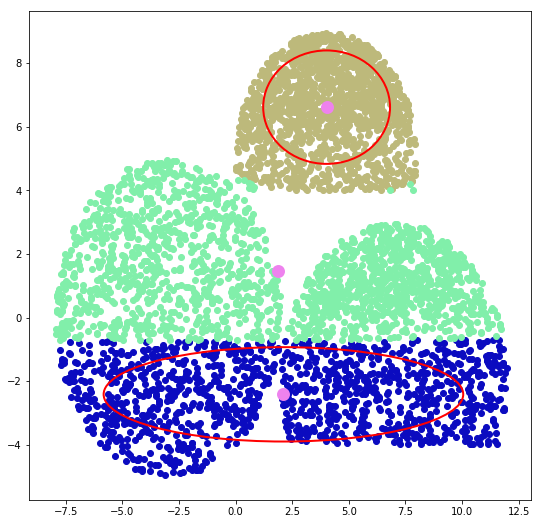

In [224]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi
    
def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in range(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print (Sigma,Pi)

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))

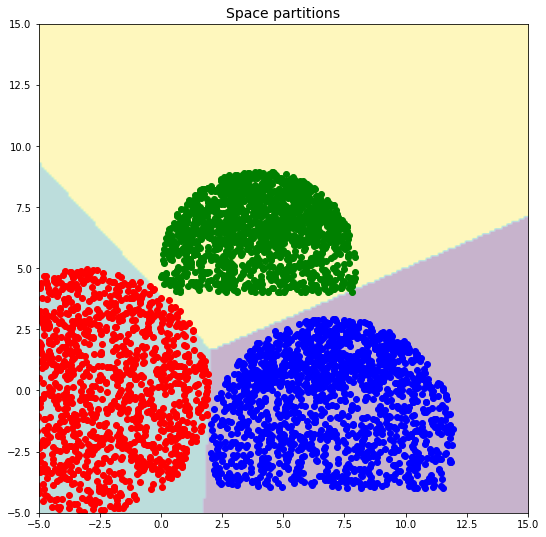

In [225]:
from sklearn import cluster

K=3
clf = cluster.KMeans(init='random', n_clusters=K)
clf.fit(X)

plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]

Z=clf.predict(data)
plt.imshow(Z.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=K-1)
plt.title('Space partitions', size=14)
fig = plt.gcf()
fig.set_size_inches((9,9))

(3, 2)
[[-3.1243819   0.0302359 ]
 [ 3.93836013  6.51974708]
 [ 6.89601759 -0.38079783]]


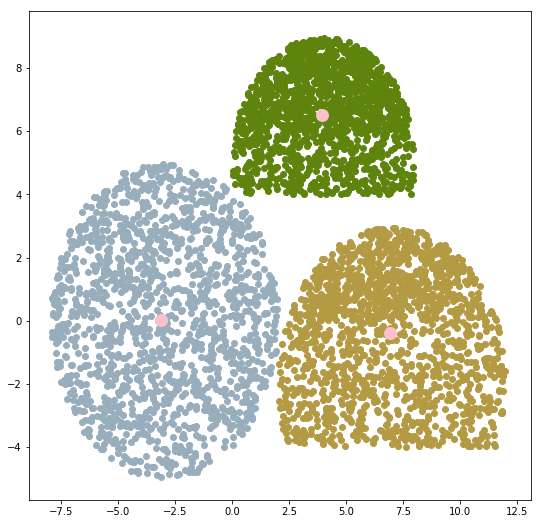

In [226]:
def soft_kmeans_iter(X,C,beta):
    #Compute membership for next iteration
    d = cdist(X, C, 'seuclidean')
    r = np.exp(-beta*d)
    r = r/(np.dot(np.sum(r, axis=1)[:,np.newaxis],np.ones((1,K)))+1e-16)
    #Update centroids
    for i in range(K):
        for dim in range(C.shape[1]):
            C[i,dim] = np.sum(X[:,dim]*r[:,i])/(np.sum(r[:,i])+1e-16)
    return C,r

        

beta=10.
C=X[:K,:]
print (C.shape)
for iter in range(1000):
    C,r = soft_kmeans_iter(X,C,beta)

print(C)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y):
    plt.scatter(X[(y==label).ravel(),0],X[(y==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=max(1200/beta,120), 
           facecolors='pink', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))